In [1]:
!pip install catboost xgboost pyswarm --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [2]:
# === Imports ===
import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from pyswarm import pso

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_2017_2020 = pd.read_csv("/content/drive/MyDrive/Network Maintenace - With & without maintenace/conference-encoded-data/Treatment-encoded-dataset-2017-2020/df_encoded_2017_2020.csv")

In [4]:
df_2017_2020.shape

(5110, 27)

In [5]:
df_2017_2020.head(10)

AADT_mean_x  AADT_Single_Unit_mean_x  AADT_Combination_mean_x  \
0       1395.0                    156.0                     54.0   
1      22429.0                    767.0                   4163.0   
2      22429.0                    767.0                   4163.0   
3      26595.0                    878.0                    186.0   
4       1964.0                     92.0                      6.0   
5       2182.0                    175.0                    242.0   
6      19601.0                    568.0                    196.0   
7      14674.0                    264.0                    205.0   
8      35793.0                   1432.0                    107.0   
9      10559.0                    443.0                     74.0   

   Future_AADT_mean_x  IRI_mean_x  Thickness_Rigid_mean_x  \
0              1590.0        82.0                     0.0   
1             22430.0       101.0                    10.0   
2             22430.0       128.0                    10.0   
3             37230.0       172.8                     0.0   
4              2750.0       287.0                     0.0   
5              3060.0       245.5                     0.0   
6             27440.0       196.5                     0.0   
7             27000.0       219.8                     0.0   
8             50110.0       209.9                     0.0   
9             19430.0       359.0                     0.0   

   Thickness_Flexible_mean_x  Base_Thickness_mean_x  F_System_mode  \
0                        6.0                   15.0              5   
1                        0.0                    6.0              1   
2                        0.0                    6.0              1   
3                        3.0                    6.0              3   
4                        3.0                    8.0              3   
5                        3.0                    8.0              3   
6                        3.0                    8.0              3   
7                        3.0                    8.0              3   
8                        3.0                    6.0              3   
9                        3.0                    8.0              3   

   Surface_Type_mode  ...  FRZ_IDX_x  TEMP_AVG_x  PRECIPITATION_x  Age_x  \
0                  6  ...     1081.5         5.6           1089.7     32   
1                  3  ...      896.3         7.3            979.6      8   
2                  3  ...      896.3         7.3            979.6      8   
3                  2  ...        3.7        19.6            933.1     24   
4                  2  ...        1.1        20.3            894.7     72   
5                  2  ...        9.0        18.7           1015.6     73   
6                  2  ...        9.0        18.7           1015.6     73   
7                  2  ...        0.0        23.0            534.0     20   
8                  2  ...        0.0        23.0            534.0     18   
9                  2  ...        0.0        23.0            534.0     45   

   Urban_Type_rural  Urban_Type_small urban  Urban_Type_urban  \
0               1.0                     0.0               0.0   
1               1.0                     0.0               0.0   
2               0.0                     1.0               0.0   
3               0.0                     0.0               1.0   
4               0.0                     0.0               1.0   
5               0.0                     0.0               1.0   
6               0.0                     0.0               1.0   
7               0.0                     0.0               1.0   
8               0.0                     0.0               1.0   
9               0.0                     0.0               1.0   

   Treatment_type_Resurfacing  Treatment_type_Thick Layers  \
0                         0.0                          0.0   
1                         0.0                          1.0   
2                         0.0                          1.0   
3         

In [6]:
df_2017_2020.isnull().sum()

AADT_mean_x                       0
AADT_Single_Unit_mean_x           0
AADT_Combination_mean_x           0
Future_AADT_mean_x                0
IRI_mean_x                        0
Thickness_Rigid_mean_x            0
Thickness_Flexible_mean_x         0
Base_Thickness_mean_x             0
F_System_mode                     0
Surface_Type_mode                 0
Base_Type_mode_x                  0
Rutting_mean_x                    0
Cracking_Percent_mean_x           0
Faulting_mean_x                   0
Last_Overlay_Thickness_mean_x     0
IRI_mean_y                        0
RHU_AV_x                         16
FRZ_IDX_x                        16
TEMP_AVG_x                       16
PRECIPITATION_x                  16
Age_x                             0
Urban_Type_rural                  0
Urban_Type_small urban            0
Urban_Type_urban                  0
Treatment_type_Resurfacing        0
Treatment_type_Thick Layers       0
Treatment_type_Thin Layers        0
dtype: int64

In [7]:
df = df_2017_2020.dropna()

In [8]:
df.shape

(5094, 27)

In [9]:
df.columns

Index(['AADT_mean_x', 'AADT_Single_Unit_mean_x', 'AADT_Combination_mean_x',
       'Future_AADT_mean_x', 'IRI_mean_x', 'Thickness_Rigid_mean_x',
       'Thickness_Flexible_mean_x', 'Base_Thickness_mean_x', 'F_System_mode',
       'Surface_Type_mode', 'Base_Type_mode_x', 'Rutting_mean_x',
       'Cracking_Percent_mean_x', 'Faulting_mean_x',
       'Last_Overlay_Thickness_mean_x', 'IRI_mean_y', 'RHU_AV_x', 'FRZ_IDX_x',
       'TEMP_AVG_x', 'PRECIPITATION_x', 'Age_x', 'Urban_Type_rural',
       'Urban_Type_small urban', 'Urban_Type_urban',
       'Treatment_type_Resurfacing', 'Treatment_type_Thick Layers',
       'Treatment_type_Thin Layers'],
      dtype='object')

In [10]:
df.drop(['Last_Overlay_Thickness_mean_x'], axis=1, inplace=True)

/tmp/ipython-input-705596893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Last_Overlay_Thickness_mean_x'], axis=1, inplace=True)


In [11]:
df.isnull().sum()

AADT_mean_x                    0
AADT_Single_Unit_mean_x        0
AADT_Combination_mean_x        0
Future_AADT_mean_x             0
IRI_mean_x                     0
Thickness_Rigid_mean_x         0
Thickness_Flexible_mean_x      0
Base_Thickness_mean_x          0
F_System_mode                  0
Surface_Type_mode              0
Base_Type_mode_x               0
Rutting_mean_x                 0
Cracking_Percent_mean_x        0
Faulting_mean_x                0
IRI_mean_y                     0
RHU_AV_x                       0
FRZ_IDX_x                      0
TEMP_AVG_x                     0
PRECIPITATION_x                0
Age_x                          0
Urban_Type_rural               0
Urban_Type_small urban         0
Urban_Type_urban               0
Treatment_type_Resurfacing     0
Treatment_type_Thick Layers    0
Treatment_type_Thin Layers     0
dtype: int64

In [12]:
df.columns

Index(['AADT_mean_x', 'AADT_Single_Unit_mean_x', 'AADT_Combination_mean_x',
       'Future_AADT_mean_x', 'IRI_mean_x', 'Thickness_Rigid_mean_x',
       'Thickness_Flexible_mean_x', 'Base_Thickness_mean_x', 'F_System_mode',
       'Surface_Type_mode', 'Base_Type_mode_x', 'Rutting_mean_x',
       'Cracking_Percent_mean_x', 'Faulting_mean_x', 'IRI_mean_y', 'RHU_AV_x',
       'FRZ_IDX_x', 'TEMP_AVG_x', 'PRECIPITATION_x', 'Age_x',
       'Urban_Type_rural', 'Urban_Type_small urban', 'Urban_Type_urban',
       'Treatment_type_Resurfacing', 'Treatment_type_Thick Layers',
       'Treatment_type_Thin Layers'],
      dtype='object')

In [13]:
num_dupes = df.duplicated(keep=False).sum()
print(f"Duplicate rows in df (all columns considered): {num_dupes}")

Duplicate rows in df (all columns considered): 8


In [14]:
# --- Remove duplicate rows across all columns ---
initial_rows = len(df)

df.drop_duplicates(inplace=True)   # modifies df in place

print(f"Duplicates removed: {initial_rows - len(df)}")
print(f"New DataFrame shape: {df.shape}")


Duplicates removed: 4
New DataFrame shape: (5090, 26)


/tmp/ipython-input-3110374706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)   # modifies df in place


In [15]:
df.shape

(5090, 26)

In [16]:
X = df.drop(columns=['IRI_mean_y'])  # Drop target column to keep 21 input features
y = df[['IRI_mean_y']]               # Target stays (N, 1)

In [17]:
y.shape

(5090, 1)

In [18]:
print(X.shape)  # Should be (4060, 21)
print(y.shape)  # Should be (4060, 1)

(5090, 25)
(5090, 1)


In [19]:
type(y)

pandas.core.frame.DataFrame

In [20]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
print(X_test.shape)

(764, 25)


In [22]:
print(X_train.shape)  # Should be [num_samples, 26]
print(y_train.shape)  # Should be [num_samples, 1] or [num_samples]

(3563, 25)
(3563, 1)


In [23]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_val_scaled = scaler_x.transform(X_val)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

In [24]:
# === Torch Dataloaders ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                        torch.tensor(y_train_scaled, dtype=torch.float32)),
                          batch_size=32, shuffle=True)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_scaled, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true_test = y_test

## ANN Optimization

In [25]:
# ==== SETUP ====
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from pyswarm import pso

save_dir = "/content/drive/MyDrive/Network Maintenace - With & without maintenace/conference-outputs/output-2017-2020/pso-ANN-ML-Minmax-2017-2020-(Maintenance)"

os.makedirs(save_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== REPRODUCIBILITY ====
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ==== INPUT DIMENSION ====
input_dim = X.shape[1]

# ==== ACTIVATION MAP ====
activation_map = {
    "sigmoid": nn.Sigmoid(),
    "logsig": nn.LogSigmoid(),
    "tansig": nn.Tanh(),
    "relu": nn.ReLU(),
    "linear": nn.Identity()
}

# ==== ANN Model ====
class ANNModel(nn.Module):
    def __init__(self, input_dim, neurons, layers, activation_name):
        super().__init__()
        act_fn = activation_map.get(activation_name, nn.Tanh())
        dims = [neurons]
        if layers >= 2: dims.append(max(4, neurons // 2))
        if layers >= 3: dims.append(max(3, neurons // 3))
        if layers >= 4: dims.append(max(3, neurons // 4))
        if layers == 5: dims.append(max(3, neurons // 5))

        layers_list = [nn.Linear(input_dim, dims[0]), act_fn]
        for i in range(1, len(dims)):
            layers_list.append(nn.Linear(dims[i - 1], dims[i]))
            layers_list.append(act_fn)
        layers_list.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.net(x)

# ==== Metrics Function ====
def calculate_metrics(y_true, y_pred):
    n = len(y_true)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(y_true - y_pred))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((y_true - y_pred) / (y_true + epsilon)))
    vaf = (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100
    rsr = rmse / np.sqrt(np.mean((y_true - np.mean(y_true))**2))
    wmap = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    m20 = np.sum(np.abs(y_true - y_pred) <= 0.2 * np.abs(y_true))
    a20index = m20 / n
    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

# ==== PSO Fitness ====
top_results = []
activation_choices = ["sigmoid", "logsig", "tanh", "relu", "linear"]

def fitness(params):
    neurons = int(params[0])
    layers = int(round(params[1]))
    activation_idx = int(round(params[2]))
    activation_name = activation_choices[activation_idx % len(activation_choices)]

    model = ANNModel(input_dim, neurons, layers, activation_name).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_r2 = -np.inf
    patience = 10
    no_improve = 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            preds = model(X_val_t).cpu().numpy()
            y_val_np = y_val_t.cpu().numpy()

        rmse, r2, mae, mape, vaf, rsr, wmap, a20index = calculate_metrics(y_val_np, preds)

        if r2 > best_val_r2:
            best_val_r2 = r2
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Store full metrics
    top_results.append((r2, rmse, mae, mape, vaf, rsr, wmap, a20index,
                        neurons, layers, activation_name))
    top_results.sort(key=lambda x: x[0], reverse=True)
    if len(top_results) > 3:
        top_results.pop()

    return -r2

# ==== Run PSO ====
top_results.clear()
lb = [
    max(8, int(0.3 * input_dim)),     # neurons lower bound
    1,                                # layers lower bound
    0                                 # activation index lower bound
]

ub = [
    min(512, int(2 * input_dim)),      # neurons upper bound
    10,                               # layers upper bound
    len(activation_choices) - 1        # activation index upper bound
]

best_params, _ = pso(fitness, lb, ub, swarmsize=10, maxiter=5)

best_neurons = int(best_params[0])
best_layers = int(round(best_params[1]))
activation_idx = int(round(best_params[2]))
best_activation = activation_choices[activation_idx]

# ==== Print Top 3 PSO Results ====
print("\n🔎 Top 3 neuron, layer, activation Configurations:")
for i, (r2, rmse, mae, mape, vaf, rsr, wmap, a20index, n, l, a) in enumerate(top_results):
    print(
        f"{i+1}. R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, "
        f"MAPE: {mape:.4f}%, VAF: {vaf:.4f}%, RSR: {rsr:.4f}, "
        f"WMAP: {wmap:.4f}%, a20index: {a20index:.4f}, "
        f"Neurons: {n}, Layers: {l}, Activation: {a}"
    )

# ==== Grid Search over Optimizer and LR ====
learning_rates = [0.01, 0.001, 0.0005]
optimizers = ['adam', 'sgd', 'rmsprop']
results = []

for lr in learning_rates:
    for opt_name in optimizers:
        model = ANNModel(input_dim, best_neurons, best_layers, best_activation).to(device)
        criterion = nn.MSELoss()
        if opt_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)

        for epoch in range(300):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_t).cpu().numpy()
            y_pred_test = scaler_y.inverse_transform(y_pred_test)

        rmse, r2, mae, mape, vaf, rsr, wmap, a20index = calculate_metrics(y_true_test, y_pred_test)
        results.append((opt_name, lr, float(r2), float(rmse), float(mae), float(mape),
                        float(vaf), float(rsr), float(wmap), float(a20index)))

results = sorted(results, key=lambda x: x[2], reverse=True)

# ==== Print Top 3 Optimizer + LR Combinations ====
print("\n⚙️ Top 3 Optimizer + LR Combinations (All Metrics):")
for i, (opt, lr, r2, rmse, mae, mape, vaf, rsr, wmap, a20index) in enumerate(results[:3]):
    print(
        f"{i+1}. Optimizer: {opt}, LR: {lr}, "
        f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, "
        f"MAPE: {mape:.4f}%, VAF: {vaf:.4f}%, "
        f"RSR: {rsr:.4f}, WMAP: {wmap:.4f}%, "
        f"a20index: {a20index:.4f}"
    )

# ==== Best Overall ====
best_result = results[0]
best_optimizer, best_lr, best_r2, best_rmse, best_mae, best_mape, best_vaf, best_rsr, best_wmap, best_a20index = best_result

print("\n🏆 Best Overall ANN Model Configuration:")
print(f"🔸 Neurons: {best_neurons}")
print(f"🔸 Hidden Layers: {best_layers}")
print(f"🔸 Activation Function: {best_activation}")
print(f"🔸 Optimizer: {best_optimizer}")
print(f"🔸 Learning Rate: {best_lr}")
print(f"🔸 R² Score: {best_r2:.4f}")
print(f"🔸 RMSE: {best_rmse:.4f}")
print(f"🔸 MAE: {best_mae:.4f}")
print(f"🔸 MAPE: {best_mape:.4f}%")
print(f"🔸 VAF: {best_vaf:.4f}%")
print(f"🔸 RSR: {best_rsr:.4f}")
print(f"🔸 WMAP: {best_wmap:.4f}%")
print(f"🔸 a20index: {best_a20index:.4f}")


Stopping search: maximum iterations reached --> 5

🔎 Top 3 neuron, layer, activation Configurations:
1. R²: 0.7118, RMSE: 0.0643, MAE: 0.0450, MAPE: 191867520.0000%, VAF: 71.5770%, RSR: 0.5369, WMAP: 31.6370%, a20index: 0.3932, Neurons: 25, Layers: 3, Activation: relu
2. R²: 0.7092, RMSE: 0.0646, MAE: 0.0460, MAPE: 120339344.0000%, VAF: 71.1813%, RSR: 0.5392, WMAP: 32.3462%, a20index: 0.3394, Neurons: 21, Layers: 3, Activation: relu
3. R²: 0.7088, RMSE: 0.0647, MAE: 0.0453, MAPE: 127612136.0000%, VAF: 71.1298%, RSR: 0.5396, WMAP: 31.8620%, a20index: 0.3578, Neurons: 25, Layers: 3, Activation: relu


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/tmp/ipython-input-3908887218.py:189: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  results.append((opt_name, lr, float(r2), float(rmse), float(mae), float(mape),
/tmp/ipython-input-3908887218.py:190: FutureWarning: C


⚙️ Top 3 Optimizer + LR Combinations (All Metrics):
1. Optimizer: sgd, LR: 0.01, R²: 0.7560, RMSE: 25.0401, MAE: 16.8053, MAPE: 21.7204%, VAF: 75.6107%, RSR: 0.4939, WMAP: 20.2739%, a20index: 0.5942
2. Optimizer: rmsprop, LR: 0.0005, R²: 0.7492, RMSE: 25.3890, MAE: 16.9674, MAPE: 20.7968%, VAF: 76.1768%, RSR: 0.5008, WMAP: 20.4694%, a20index: 0.6099
3. Optimizer: adam, LR: 0.0005, R²: 0.7491, RMSE: 25.3913, MAE: 16.7489, MAPE: 20.3749%, VAF: 75.5110%, RSR: 0.5009, WMAP: 20.2058%, a20index: 0.6086

🏆 Best Overall ANN Model Configuration:
🔸 Neurons: 25
🔸 Hidden Layers: 3
🔸 Activation Function: relu
🔸 Optimizer: sgd
🔸 Learning Rate: 0.01
🔸 R² Score: 0.7560
🔸 RMSE: 25.0401
🔸 MAE: 16.8053
🔸 MAPE: 21.7204%
🔸 VAF: 75.6107%
🔸 RSR: 0.4939
🔸 WMAP: 20.2739%
🔸 a20index: 0.5942


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/tmp/ipython-input-3908887218.py:189: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  results.append((opt_name, lr, float(r2), float(rmse), float(mae), float(mape),
/tmp/ipython-input-3908887218.py:190: FutureWarning: C

In [26]:
# ==== Final ANN Training with Best Hyperparameters ====
final_model = ANNModel(input_dim, best_neurons, best_layers, best_activation).to(device)
criterion = nn.MSELoss()

# Select optimizer
if best_optimizer == 'adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_lr)
elif best_optimizer == 'sgd':
    optimizer = optim.SGD(final_model.parameters(), lr=best_lr, momentum=0.9)
elif best_optimizer == 'rmsprop':
    optimizer = optim.RMSprop(final_model.parameters(), lr=best_lr)

# Train the ANN
for epoch in range(300):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()

# ==== Predict ====
final_model.eval()
with torch.no_grad():
    y_pred_test_ann = final_model(X_test_t).cpu().numpy()
    y_pred_test_ann = scaler_y.inverse_transform(y_pred_test_ann)

# ==== Calculate ANN Metrics ====
rmse_ann, r2_ann, mae_ann, mape_ann, vaf_ann, rsr_ann, wmap_ann, a20index_ann = calculate_metrics(y_true_test, y_pred_test_ann)

# ==== Convert Series to scalar if needed ====
rmse_ann = float(rmse_ann)
r2_ann = float(r2_ann)
mae_ann = float(mae_ann)
mape_ann = float(mape_ann)
vaf_ann = float(vaf_ann)
rsr_ann = float(rsr_ann)
wmap_ann = float(wmap_ann)
a20index_ann = float(a20index_ann)

# Save ANN metrics as a tuple
ann_metrics = (
    rmse_ann,
    r2_ann,
    mae_ann,
    mape_ann,
    vaf_ann,
    rsr_ann,
    wmap_ann,
    a20index_ann
)

# ==== Print final ANN metrics ====
print("\n📊 Final ANN Performance Metrics:")
print(f"🔹 R² Score: {r2_ann:.4f}")
print(f"🔹 RMSE: {rmse_ann:.4f}")
print(f"🔹 MAE: {mae_ann:.4f}")
print(f"🔹 MAPE: {mape_ann:.4f}%")
print(f"🔹 VAF: {vaf_ann:.4f}%")
print(f"🔹 RSR: {rsr_ann:.4f}")
print(f"🔹 WMAP: {wmap_ann:.4f}%")
print(f"🔹 a20index: {a20index_ann:.4f}")


📊 Final ANN Performance Metrics:
🔹 R² Score: 0.7568
🔹 RMSE: 25.0003
🔹 MAE: 16.6753
🔹 MAPE: 21.1377%
🔹 VAF: 75.7595%
🔹 RSR: 0.4932
🔹 WMAP: 20.1170%
🔹 a20index: 0.5995


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/tmp/ipython-input-302843060.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r2_ann = float(r2_ann)
/tmp/ipython-input-302843060.py:36: FutureWarning: Calling float on a single element Series is deprecated and wi

## Machine Learning Models

In [27]:
# === Evaluation Function ===
def evaluate_model(model, name):
    # Predictions and true values
    y_pred = scaler_y.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))
    y_true = y_test.values

    # Metrics calculation
    n = len(y_true)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    mae = np.mean(np.abs(y_true - y_pred))
    epsilon = 1e-10
    mape = (100 / n) * np.sum(np.abs((y_true - y_pred) / (y_true + epsilon)))
    vaf = (1 - np.var(y_true - y_pred) / np.var(y_true)) * 100
    rsr = rmse / np.sqrt(np.mean((y_true - np.mean(y_true)) ** 2))
    wmap = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    m20 = np.sum(np.abs(y_true - y_pred) <= 0.2 * np.abs(y_true))
    a20index = m20 / n

    # Print results
    print(f"🔹 {name}:")
    print(f"   R²       = {r2:.4f}")
    print(f"   RMSE     = {rmse:.4f}")
    print(f"   MAE      = {mae:.4f}")
    print(f"   MAPE     = {mape:.4f}%")
    print(f"   VAF      = {vaf:.4f}%")
    print(f"   RSR      = {rsr:.4f}")
    print(f"   WMAPE    = {wmap:.4f}%")
    print(f"   a20index = {a20index:.4f}")

    return rmse, r2, mae, mape, vaf, rsr, wmap, a20index

In [28]:
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train_scaled.ravel())
rf_metrics = evaluate_model(rf_grid.best_estimator_, "Random Forest")
rf_metrics

🔹 Random Forest:
   R²       = 0.7586
   RMSE     = 24.9055
   MAE      = 15.8838
   MAPE     = 19.4548%
   VAF      = 75.9484%
   RSR      = 0.4913
   WMAPE    = 19.1622%
   a20index = 0.6688


(np.float64(24.9054734110704),
 np.float64(0.7586436705764764),
 np.float64(15.883848477624037),
 np.float64(19.45480117699354),
 np.float64(75.94844969853199),
 np.float64(0.49128029618897145),
 np.float64(19.162218059162004),
 np.float64(0.668848167539267))

In [29]:
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}, cv=5, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train_scaled.ravel())
xgb_metrics = evaluate_model(xgb_grid.best_estimator_, "XGBoost")
xgb_metrics

🔹 XGBoost:
   R²       = 0.7747
   RMSE     = 24.0606
   MAE      = 16.0283
   MAPE     = 20.1947%
   VAF      = 77.5328%
   RSR      = 0.4746
   WMAPE    = 19.3364%
   a20index = 0.6453


(np.float64(24.06058953440657),
 np.float64(0.7747412767631244),
 np.float64(16.02825504872187),
 np.float64(20.19472778919088),
 np.float64(77.53280477071347),
 np.float64(0.47461428890929486),
 np.float64(19.336429630649278),
 np.float64(0.6452879581151832))

In [30]:
cat_grid = GridSearchCV(CatBoostRegressor(verbose=0, random_state=42), {
    'iterations': [300, 500, 1000],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}, cv=5, scoring='r2', n_jobs=-1)
cat_grid.fit(X_train_scaled, y_train_scaled.ravel())
cat_metrics = evaluate_model(cat_grid.best_estimator_, "CatBoost")
cat_metrics

🔹 CatBoost:
   R²       = 0.7896
   RMSE     = 23.2513
   MAE      = 15.3516
   MAPE     = 19.3653%
   VAF      = 79.0288%
   RSR      = 0.4587
   WMAPE    = 18.5202%
   a20index = 0.6688


(np.float64(23.251321088128027),
 np.float64(0.7896394213176892),
 np.float64(15.351637954747352),
 np.float64(19.365297275136243),
 np.float64(79.02877969053361),
 np.float64(0.45865082435586096),
 np.float64(18.52016118565869),
 np.float64(0.668848167539267))

## Comparisons

In [31]:
import pandas as pd

# === Create DataFrame ===
df_results = pd.DataFrame([
    {"Model": "ANN",
     "R2": ann_metrics[1], "RMSE": ann_metrics[0], "MAE": ann_metrics[2], "MAPE": ann_metrics[3],
     "VAF": ann_metrics[4], "RSR": ann_metrics[5], "WMAP": ann_metrics[6], "A20Index": ann_metrics[7]},

    {"Model": "Random Forest",
     "R2": rf_metrics[1], "RMSE": rf_metrics[0], "MAE": rf_metrics[2], "MAPE": rf_metrics[3],
     "VAF": rf_metrics[4], "RSR": rf_metrics[5], "WMAP": rf_metrics[6], "A20Index": rf_metrics[7]},

    {"Model": "XGBoost",
     "R2": xgb_metrics[1], "RMSE": xgb_metrics[0], "MAE": xgb_metrics[2], "MAPE": xgb_metrics[3],
     "VAF": xgb_metrics[4], "RSR": xgb_metrics[5], "WMAP": xgb_metrics[6], "A20Index": xgb_metrics[7]},

    {"Model": "CatBoost",
     "R2": cat_metrics[1], "RMSE": cat_metrics[0], "MAE": cat_metrics[2], "MAPE": cat_metrics[3],
     "VAF": cat_metrics[4], "RSR": cat_metrics[5], "WMAP": cat_metrics[6], "A20Index": cat_metrics[7]}
])

# === Ensure all columns are float ===
for col in ["R2", "RMSE", "MAE", "MAPE", "VAF", "RSR", "WMAP", "A20Index"]:
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

# === Format percentage columns ===
for col in ['MAPE', 'VAF', 'WMAP']:
    df_results[col] = df_results[col].map(lambda x: f"{x:.2f}%")

# === Format other numeric columns ===
for col in ['R2', 'RMSE', 'MAE', 'RSR', 'A20Index']:
    df_results[col] = df_results[col].map(lambda x: f"{x:.4f}")

# === Display results ===
pd.set_option('display.max_columns', None)
df_results


Model      R2     RMSE      MAE    MAPE     VAF     RSR    WMAP  \
0            ANN  0.7568  25.0003  16.6753  21.14%  75.76%  0.4932  20.12%   
1  Random Forest  0.7586  24.9055  15.8838  19.45%  75.95%  0.4913  19.16%   
2        XGBoost  0.7747  24.0606  16.0283  20.19%  77.53%  0.4746  19.34%   
3       CatBoost  0.7896  23.2513  15.3516  19.37%  79.03%  0.4587  18.52%   

  A20Index  
0   0.5995  
1   0.6688  
2   0.6453  
3   0.6688

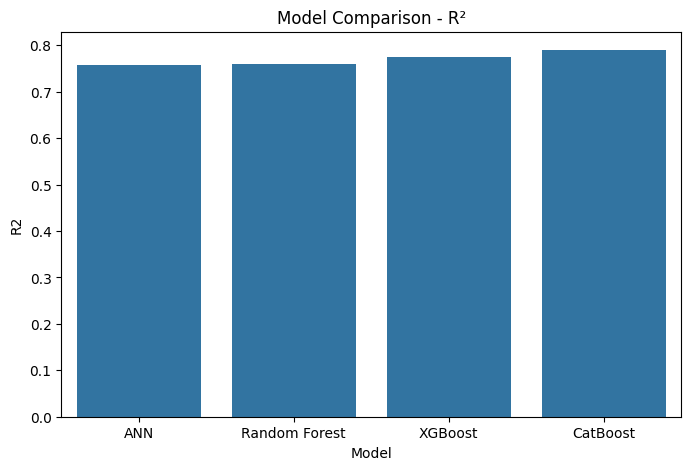

In [32]:
df_results_plot = df_results.copy()
df_results_plot['R2'] = df_results_plot['R2'].str.rstrip('%').astype(float)
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='R2', data=df_results_plot)
plt.title('Model Comparison - R²')
plt.show()